Using Transfer Learning to do classification instead of making a model from scratch.

We will making a food classifier to identify 10 different food items.
We will be making 3 differnt models using one of each of this pretrained model:
- mobilnet_V2
- efficentnet
- resnet_50

In [ ]:
#Lets start by loading the data set
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzipe the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_data_dir = "10_food_classes_10_percent/train/"
test_data_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training Data:")
train_data = train_datagen.flow_from_directory(train_data_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = "categorical")

print("Testing Data:")
test_data = test_datagen.flow_from_directory(test_data_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training Data:
Found 750 images belonging to 10 classes.
Testing Data:
Found 2500 images belonging to 10 classes.


In [3]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [4]:
import tensorflow_hub as hub
from tensorflow.keras import layers

mobilenet_v3_url = "https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-075-224-classification/versions/1"
efficentnetB0_v2_url = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2"
resnet_v2_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"

In [5]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model


# Let's make and complie all three models

In [6]:
mobilenet_model = create_model(model_url = mobilenet_v3_url, num_classes = 10)

mobilenet_model.compile(loss = "categorical_crossentropy",
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

In [7]:
efficentnet_model = create_model(efficentnetB0_v2_url, 10)

efficentnet_model.compile(loss = "categorical_crossentropy",
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

In [8]:
resnet_model = create_model(resnet_v2_url, 10)

resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [19]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_NNmodel_curves(history, name):
  """
  Args:
  history: History of model training

  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title(name + ' Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title(name + ' Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [ ]:
history_mobilenet = mobilenet_model.fit(train_data,
                      epochs = 10,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = len(test_data),
                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="mobilenet_v3")])

In [ ]:
history_efficentnet = efficentnet_model.fit(train_data,
                        epochs = 10,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks = [create_tensorboard_callback(
                            dir_name = "tensorflow_hub",
                            experiment_name = "efficentnet_B0_v2")])

In [ ]:
history_resnet = resnet_model.fit(train_data,
                  epochs = 10,
                  steps_per_epoch = len(train_data),
                  validation_data = test_data,
                  validation_steps = len(test_data),
                  callbacks = [create_tensorboard_callback(
                      dir_name = "tensorflow_hub",
                      experiment_name = "resnet_50_v2"
                  )])

# Let's plot a graph with loss and accuracy data from all three models, to better visualize the data

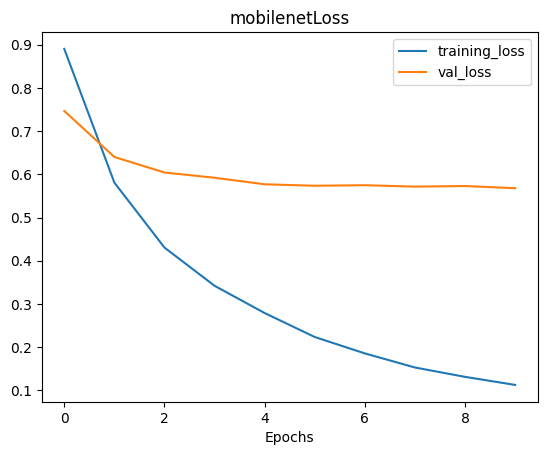

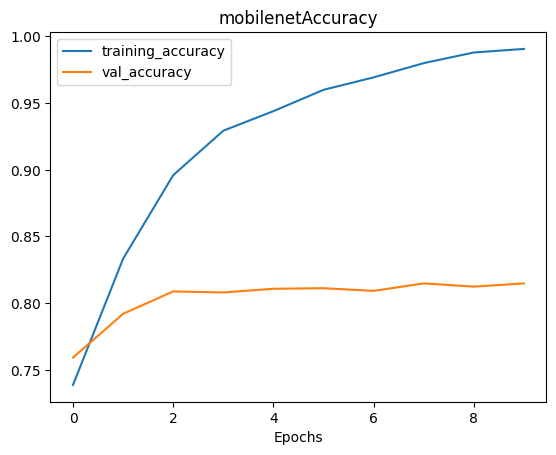

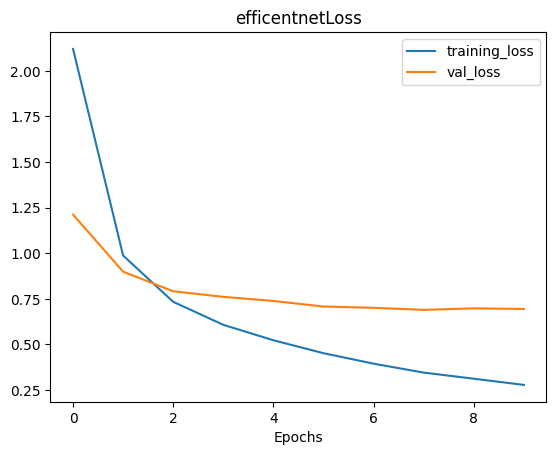

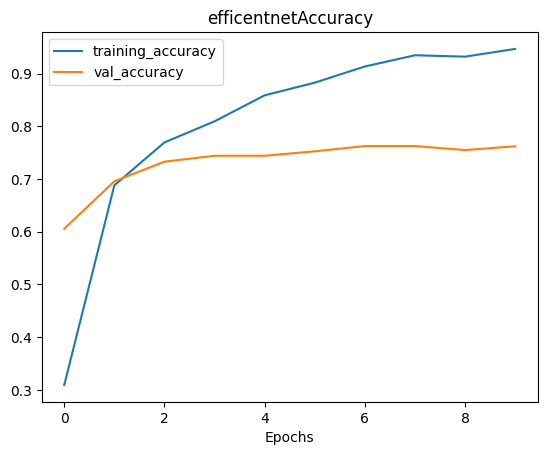

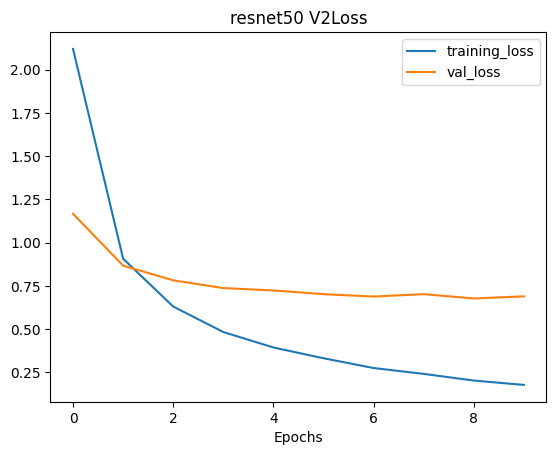

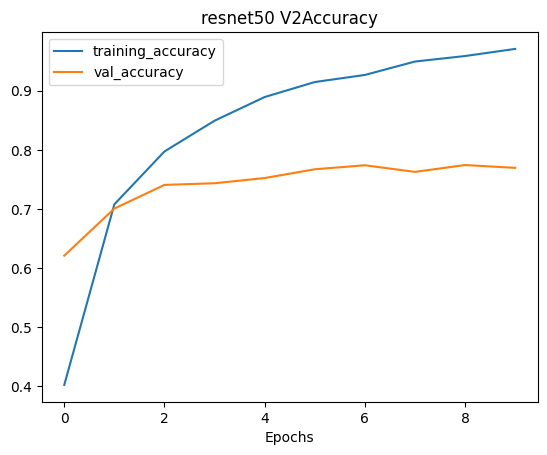

In [20]:
plot_NNmodel_curves(history_mobilenet, name = "mobilenet")
plot_NNmodel_curves(history_efficentnet, name = "efficentnet")
plot_NNmodel_curves(history_resnet, name = "resnet50 V2")